In [60]:
import random
import torch
import d2l
import numpy as np
import matplotlib.pyplot as plt

# 3.4.6. Exercises

## 1. What would happen if we were to initialize the weights to zero. Would the algorithm still work? What if we initialized the parameters with variance 1000 rather than 0.1?

### origin model(initialize the weights with norm(0,0.01))

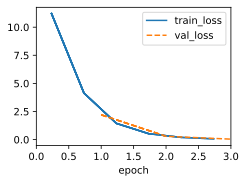

In [15]:
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
model = d2l.LinearRegressScratch(2, lr=0.03)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model,data)

### Initialize the weights with zero

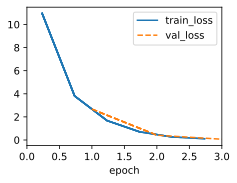

In [5]:
model = d2l.LinearRegressScratch(2, lr=0.03,sigma = 0)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model,data)

### Initialize the weights with norm(0,1000)

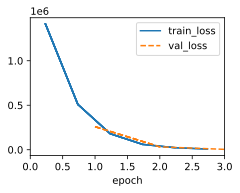

In [6]:
model = d2l.LinearRegressScratch(2, lr=0.03,sigma=1000)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model,data)

## 2. Assume that you are Georg Simon Ohm trying to come up with a model for resistors that relate voltage and current. Can you use automatic differentiation to learn the parameters of your model?

In this context, starting from Ohm's Law, it is understood that the current passing through a resistor is directly proportional to the voltage applied:
$$
V = I \cdot R 
$$


Where:
* $V$ represents voltage
* $I$ represents current
* $R$ represents resistance

So we generate synthetic data $V$ and $I$ with a parameter $R$ and build a line regression model to simulate the relationship between voltage and current. Meanwhile MSE is employed as the loss function to quantify the difference between predicted and actual voltages. Utilizing the stochastic gradient descent (SGD) optimizer, a training loop encompasses forward and backward propagation, as well as parameter updates. As training progresses, the model gradually adjusts the value of parameter $R$, allowing the predicted voltage to approach the actual voltage.

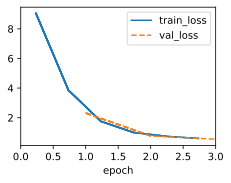

In [27]:
data = d2l.SyntheticRegressionData(w=torch.tensor([5.1]), b=0, noise=1)
model = d2l.LinearRegressScratch(1, lr=0.03)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model,data)

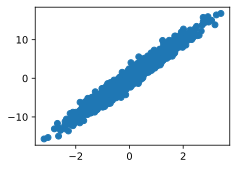

In [28]:
plt.scatter(data.X, data.y)
plt.show()

In [29]:
print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([0.3010], grad_fn=<SubBackward0>)
error in estimating b: tensor([-0.0321], grad_fn=<RsubBackward1>)


## 3. Can you use [Planck’s Law](https://en.wikipedia.org/wiki/Planck%27s_law) to determine the temperature of an object using spectral energy density? For reference, the spectral density of radiation emanating from a black body is 
$$
B(\lambda, T)=\frac{2 h c^2}{\lambda^5} \cdot\left(\exp \frac{h c}{\lambda k T}-1\right)^{-1}
$$

Here 
* $\lambda$ is the wavelength
* $T$ is the temperature 
* $c$ is the speed of light 
* $h$ is Planck’s quantum 
* $k$ is the Boltzmann constant

You measure the energy for different wavelengths $\lambda$ and you now need to fit the spectral density curve to Planck’s law.

In [82]:
class SyntheticPlankData(d2l.DataModule):
    def __init__(self, T, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        c = 299792458
        h = 6.6260701e-34
        k = 1.380649e-23
        n = num_train + num_val
        self.X = torch.arange(1,n) * 300 / n
        noise = random.random() * noise
        self.y = 2*h*c**2/self.X
        
    def get_tensorloader(self, tensor, train, indices=slice(0, None)):
        tensor = tuple(a[indices] for a in tensor)
        dataset = torch.utils.data.TensorDataset(*tensor)
        return torch.utils.data.DataLoader(dataset, self.batch_size,
                                           shuffle=train)

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)

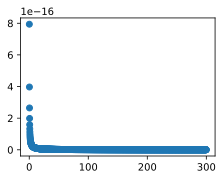

In [89]:
data = SyntheticPlankData(4000)
plt.scatter(data.X, data.y)
plt.show()

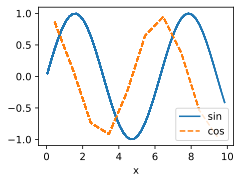

In [2]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)